# Download dataset from kaggle and split dataset




### Download dataset

In [29]:
! pip install -q kaggle


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 ! kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:07<00:00, 120MB/s]
100% 1.04G/1.04G [00:07<00:00, 144MB/s]


In [ ]:
! mkdir train
! unzip flickr8k.zip -d train

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

### Import libraries

In [30]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from numpy import array
from pickle import dump, load


### Read captions.txt and split captions into training and testing

Dataset consists of roughly 8000 images, each image has 5 captions

In [ ]:
df = pd.read_csv("/content/train/captions.txt")
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


80% for training, rest for testing

In [ ]:
train, testing = np.split(df, [int(0.8*len(df))])
print(len(df), train.shape, testing.shape)

40455 (32364, 2) (8091, 2)


Image path

In [ ]:
image_path = '/content/train/Images/'

Let's see the first image and its captions

0    A child in a pink dress is climbing up a set o...
1                A girl going into a wooden building .
2     A little girl climbing into a wooden playhouse .
3    A little girl climbing the stairs to her playh...
4    A little girl in a pink dress going into a woo...
Name: caption, dtype: object


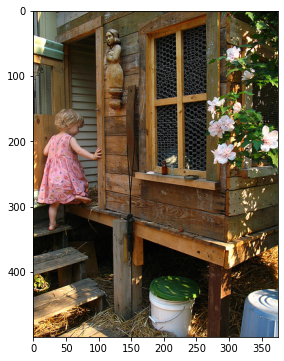

In [ ]:
n = 0
img = Image.open(image_path + df['image'][n])
plt.figure(figsize=(6,6))
plt.imshow(img)
print(df['caption'][n*5:n*5+5])

Dimension of every image

In [ ]:
for i in range(5):
  img = Image.open(image_path + df['image'][i])
  print(img.size)

(375, 500)
(375, 500)
(375, 500)
(375, 500)
(375, 500)


# Preprocessing captions

Remove punctuations, special characters, words containing numbers for every caption

In [ ]:
import re
def caption_preprocessing(text, remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]' # not characters or numbers
  text=re.sub(pattern,'',text) # re.sub returns a string after replacing the matched pattern in a string with a replacement.
  
  # tokenize
  text=text.split()
  # convert to lower case
  text = [word.lower() for word in text]
   
  # remove tokens with numbers in them
  text = [word for word in text if word.isalpha()]
  # store as string
  
  text =  ' '.join(text)
  # insert 'startseq', 'endseq' at before and at the end of sentence
  text = 'startseq ' + text + ' endseq'
  return text

print(caption_preprocessing('xin chao //$#$%$ ban ]]] toi ten khoa.'))

startseq xin chao ban toi ten khoa endseq


 Applying preprocessing into the captions

In [ ]:
df['caption'] = df['caption'].apply(caption_preprocessing)

In [ ]:
print(df['caption'][:10])

0    startseq a child in a pink dress is climbing u...
1    startseq a girl going into a wooden building e...
2    startseq a little girl climbing into a wooden ...
3    startseq a little girl climbing the stairs to ...
4    startseq a little girl in a pink dress going i...
5    startseq a black dog and a spotted dog are fig...
6    startseq a black dog and a tricolored dog play...
7    startseq a black dog and a white dog with brow...
8    startseq two dogs of different breeds looking ...
9    startseq two dogs on pavement moving toward ea...
Name: caption, dtype: object


### Count the number of words in dataset and max_length of captions

Then, count the occurences of unique words in caption dataset to get vocab_size and find out the max length of all captions. 

Max_length: hidden state length of LSTM

In [ ]:
word_counts = {}
max_length = 0
for text in df['caption']:
  words = text.split()
  
  if(max_length<len(words)):
    max_length = len(words)
  else:
    max_length = max_length
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1
print(len(word_counts))
print(max_length)

8777
37


In [ ]:
count = 0
max_length = 0
word_counts = {}
for text in df['caption']:
  words = text.split()
  count += 1
  if(max_length < len(words)):
    max_length = len(words)
  print(words)
  for word in words:
    try:
      word_counts[word] += 1
    except:
      word_counts[word] = 1
  if count == 1:
    break

print(word_counts)

['startseq', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'endseq']
{'startseq': 1, 'a': 3, 'child': 1, 'in': 2, 'pink': 1, 'dress': 1, 'is': 1, 'climbing': 1, 'up': 1, 'set': 1, 'of': 1, 'stairs': 1, 'an': 1, 'entry': 1, 'way': 1, 'endseq': 1}


Reduce size of vocab, only accept words that appear more than 10 times

In [ ]:
vocab = [word for word in word_counts if word_counts[word] >= 10]
print(len(word_counts), '---->', len(vocab))

8777 ----> 1952


Index to word & word to index

In [ ]:
i2w = {}
w2i = {}

id = 1
for word in vocab:
    w2i[word] = id
    i2w[id] = word
    id += 1

print(len(i2w), len(w2i))
print(i2w[1])

1952 1952
startseq


# Embedding word using Glove

Mapping the every word (index) to a 200-long vector and for this purpose, we will use a pre-trained GLOVE Model

GLOVE provides 4 text files containing word vectors. We use glove.6B which was trained on Wikipedia 2014 + Gigaword 5



In [ ]:
! wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-03-10 11:52:13--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-10 11:52:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip         16%[==>                 ] 136.27M  5.11MB/s    eta 2m 8s  ^C


In [ ]:
! mkdir glove
! unzip glove.6B.zip -d glove

Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  



We choose file glove.6B.200d.txt, meaning every word will be represented by a vector (200,)

In [ ]:
embeddings_index = {} # empty dictionary
file = open('/content/glove/glove.6B.200d.txt', encoding="utf-8")

for line in file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
file.close()
print('Found %s word vectors.' % len(embeddings_index))

FileNotFoundError: ignored

In [ ]:
embeddings_index['of']

KeyError: ignored

In [ ]:
embedding_dim = embeddings_index['u.s'].shape[0] # = 200
vocab_size = len(vocab) + 1 # add 1 more padding

KeyError: ignored

In [ ]:
print(vocab_size)

1953


For all the 1952  unique words in our vocabulary, we create an embedding matrix which will be loaded into the model before training.

Matrix size = (1952, 200)


In [ ]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

count = 0
# for every word and its index
for word, index in w2i.items():
    embedding_vector = embeddings_index.get(word)
    # if embedding_vector is not None:
    #     # Words not found in the embedding index will be all zeros
    #     embedding_matrix[i] = embedding_vector
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

print(embedding_matrix.shape)

NameError: ignored

In [ ]:
from pickle import dump, load

In [ ]:
with open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/embedding_matrix.pkl", "wb") as file:
    dump(embedding_matrix, file)

OSError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embedding_matrix = load(open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/embedding_matrix.pkl", "rb"))
embedding_matrix.shape

OSError: ignored

# Transfer learning on images, using Inception V3 and Resize Images



### Using pre-trained model V3



We use Inception V3, remove the last layer (fully connected layer) to get the features vectors of images

Our purpose here is to get fixed-length informative vector for each image. This process is called automatic feature engineering.

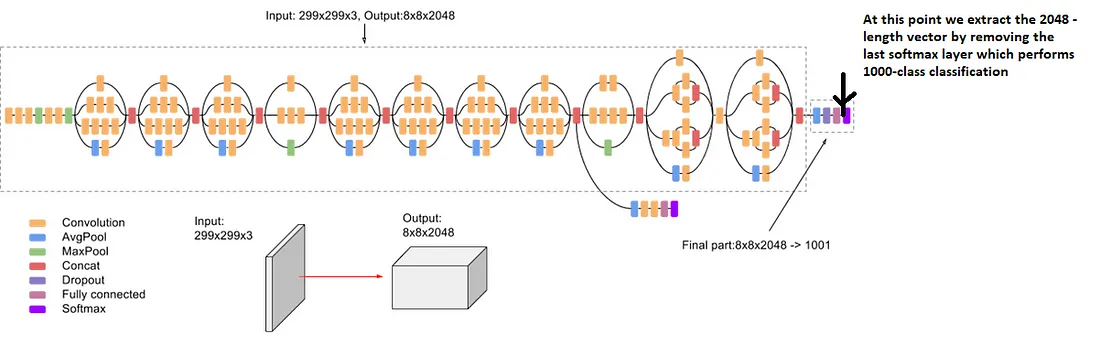

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model = InceptionV3()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.models import Model
# New model from model InceptionV3 with last layer removed
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
model_new.input_shape

(None, 299, 299, 3)

### Create two dictionaries images and captions



> images:

    .key: image_name

    .value: a corresponding matched image

>captions: 

    . key: image_name

    . values: list of its(current image_name) corresponding captions

In [ ]:
images = {}
captions = {}

for i in range(len(df)):
  images[df['image'][i]] = np.array(Image.open(image_path + df['image'][i]))
  try:
    captions[df['image'][i]].append(df['caption'][i])
  except:
    captions[df['image'][i]] = [df['caption'][i]]
  
print(len(images), len(captions))


just testing

In [ ]:

captions = {}

start = time()
for i in range(len(df)):
  #images[df['image'][i]] = np.array(Image.open(image_path + df['image'][i]))
  print()
  print('i', i)
  try:
    captions[df['image'][i]].append(df['caption'][i])
    print('try')
    print(captions)
  except:
    captions[df['image'][i]] = [df['caption'][i]]
    print('except')
    print(captions)
  if i == 5:
    break
  
print('final', captions)


In [ ]:
print(captions[df['image'][1]] == captions[df['image'][4]])

### Dumping captions into drive

In [ ]:
with open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/encoded_captions.pkl", "wb") as file:
    dump(captions, file)

In [ ]:
captions = load(open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/encoded_captions.pkl", "rb"))
len(captions)

8091

In [ ]:
images[df['image'][0]].shape

In [ ]:
tmp = np.array([[0,2,1],[3,5,6]])
tmp = np.expand_dims(tmp, axis=0)
tmp

### Resize image & Function to encode a given image into a vector of size (2048, )


Input size of model is 299x299, our image dim is 375x500. So we will need to resize our images shape

In [ ]:
from keras.applications.inception_v3 import preprocess_input
# Image embedding thành vector (2048, )
def encode(image):
    # Convert all the images to size 299x299 to match the input size of model InceptionV3
    img = np.resize(image, (299, 299, 3 ))
    # Add one more dimension
    img = np.expand_dims(img, axis=0)
    # preprocess the images using preprocess_input() from inception module
    img = preprocess_input(img)
    # encode all the train images
    feature_vectors = model_new.predict(img) # Get the encoding vector for the image
    feature_vectors = np.reshape(feature_vectors, feature_vectors.shape[1]) # reshape from (1, 2048) to (2048, )
    return feature_vectors

In [ ]:
# Encoding all images in training dataset
start = time()
encoding_image = {}
for id, img in images.items():
    encoding_image[id] = encode(img)
print("Time taken =", time()-start)

In [ ]:
encoding_image['2089542487_b4c1ee7025.jpg'].shape

NameError: ignored

In [ ]:
train_features = encoding_image

In [ ]:
from pickle import dump, load
with open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/encoded_train_images.pkl", "wb") as file:
    dump(encoding_image, file)

In [ ]:
train_features = load(open("/content/gdrive/My Drive/Colab Notebooks/Image Captioning/encoded_train_images.pkl", "rb"))
len(train_features)

8091

# Training


We use merge architecture, process image and caption separately then merge the image with the output of RNN after processing the word

input = [X_image, X_caption]

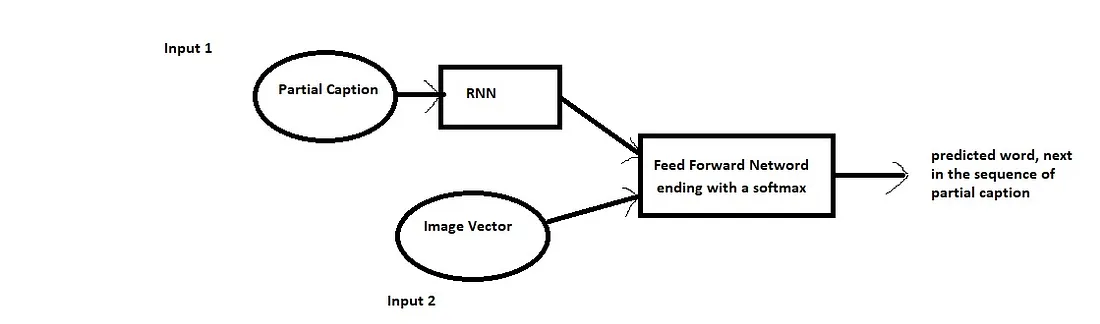

### Import libraries

In [ ]:


from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras import Input
from tensorflow.keras import optimizers

### Create model

In [ ]:
#  features extractor model

inputs_feature_extractor = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs_feature_extractor)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model

input_caption_sequence = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(input_caption_sequence)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs_feature_extractor, input_caption_sequence], outputs=outputs)


In [ ]:
model.summary()
print('-------------')
print('Plotting model')
print('-------------')
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### Data Preparation using Generator Function

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(captions, images, w2i, max_length, batch_size):

  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for id, caps in captions.items():
      n += 1
      image = images[id]
      for cap in caps:
        # encode the sequence
        seq = [w2i[word] for word in cap.split(' ') if word in w2i]

        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          
          # store
          X_image.append(image)
          X_cap.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        yield ([np.array(X_image), np.array(X_cap)], np.array(y))
        X_image, X_cap, y = [], [], []
        n = 0


### Including the embedded matrix to the model

The embedding matrix from a pre-trained Glove model needs to be included in the model before starting the training:



Notice that since we are using a pre-trained embedding layer, we need to freeze it (trainable = False), before training the model, so that it does not get updated during the backpropagation.



In [ ]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

### Compile and train model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.optimizer.lr = 0.0001


In [ ]:
checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/Image Captioning/cp.ckpt"

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
cp_callback = ModelCheckpoint(filepath=checkpoint_path,save_best_only=False, save_weights_only=True, verbose=1)

In [ ]:
generator = data_generator(captions=captions, images=train_features, w2i=w2i, max_length=max_length, batch_size=16)
model.fit(generator, epochs=5, steps_per_epoch=len(train_features), verbose=1, callbacks=[cp_callback])

In [ ]:
model.fit(generator, epochs=1, steps_per_epoch=len(train_features), verbose=1, callbacks=[cp_callback])

8091/8091 [==============================] - ETA: 0s - loss: 0.1897
Epoch 1: saving model to /content/gdrive/My Drive/Colab Notebooks/Image Captioning/cp.ckpt
8091/8091 [==============================] - 1417s 175ms/step - loss: 0.1897


In [ ]:
model.save_weights('/content/gdrive/My Drive/Colab Notebooks/Image Captioning/model.h5')

In [ ]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Image Captioning/model.h5')

# Load model and inference 

In [ ]:
from tensorflow.keras.models import load_model
model_new = load_model('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/model.h5')


In [ ]:
model_new.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 37, 200)      390600      ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [w2i[w] for w in in_text.split() if w in w2i]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model_new.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = i2w[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


250    startseq a black and white dog is attempting t...
251    startseq a black and white dog jumps after a y...
252    startseq a black and white dog jumps to get th...
253    startseq a black dog is jumping up to catch a ...
254           startseq a dog jumps to catch a toy endseq
Name: caption, dtype: object


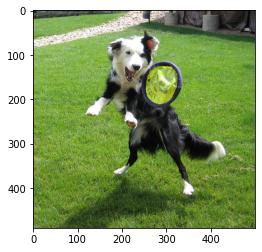

a black and white dog jumps after a yellow toy


In [ ]:
pic = list(train_features.keys())[50]
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + pic)
print(df['caption'][df['image'] == pic])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print(predict)

In [ ]:
image = (train_features[pic].reshape((1,2048)))
image_no_change = train_features[pic]

print(image.shape, image_no_change.shape)

KeyError: ignored

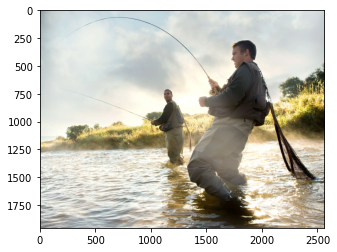

In [ ]:
pic = 'fishing.jpg'
image = Image.open(pic)
# image = train_features[pic].reshape((1,2048))
# img = Image.open(image_path + pic)
# print(df['caption'][df['image'] == pic])
plt.imshow(image)
plt.show()
# predict = greedySearch(image)
# print(predict)

In [ ]:
pic

'1067180831_a59dc64344.jpg'

30    startseq a black and white dog is running in a...
31    startseq a black and white dog is running thro...
32    startseq a boston terrier is running in the gr...
33    startseq a boston terrier is running on lush g...
34    startseq a dog runs on the green grass near a ...
Name: caption, dtype: object


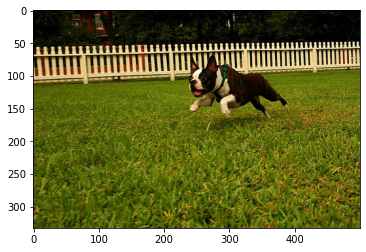

a black and white dog is running through the grass


In [ ]:
pic = '102351840_323e3de834.jpg'
image = train_features[pic].reshape((1,2048))
img = Image.open(image_path + pic)
print(df['caption'][df['image'] == pic])
plt.imshow(img)
plt.show()
predict = greedySearch(image)
print(predict)